In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image,make_grid
import matplotlib.pyplot as plt


# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 40

ZDIMS = 20


torch.manual_seed(SEED)

if CUDA:
    torch.cuda.manual_seed(SEED)


kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}



In [2]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)




In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        

        # DECODER
        
        self.fc3 = nn.Linear(ZDIMS, 400)
        
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):

        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x) :
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if CUDA:
    model.cuda()




In [19]:
def loss_function(recon_x, x, mu, logvar):
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784),reduction='mean')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)




In [23]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        # data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):

    model.eval()
    test_loss = 0

    with torch.no_grad():
        
      for i, (data, _) in enumerate(test_loader):
          if CUDA:
              # make sure this lives on the GPU
              data = data.cuda()

          # we're only going to infer, so no autograd at all required: volatile=True
          # data = Variable(data, volatile=True)
          recon_batch, mu, logvar = model(data)
          test_loss += loss_function(recon_batch, data, mu, logvar).item()
          if i == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n],
                                    recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
            os.makedirs('results',exist_ok=True)
            save_image(comparison.data.cpu(),
                      'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    imgg = make_grid( comparison.data.cpu())
    plt.imshow(imgg.permute(1,2,0))



Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001021
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.001000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.001045
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001023
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.000982
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001008
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001035
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001008
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001005
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001006
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001001
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001010
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001026
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001042
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001061
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.000997
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001030
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.000992
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001029
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001047
Train Epoch: 1 [

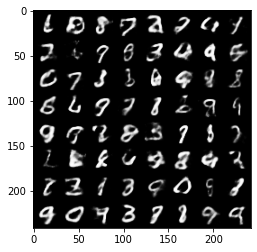

In [21]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = torch.randn(64, ZDIMS)
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')
    sample_img = make_grid(sample.data.view(64, 1, 28, 28)  )
    plt.imshow(sample_img.permute(1,2,0))

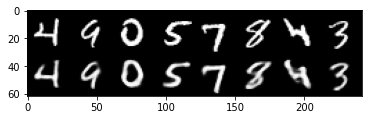

In [22]:
import imageio

reconstructed_img = imageio.imread('results/reconstruction_40.png')
plt.imshow(reconstructed_img)